In [11]:
import os
import pandas as pd
import numpy as np
from PIL import Image

data_root = "./dataset"

In [12]:
csv_file = os.path.join(data_root, "image_data.csv")
df = pd.read_csv(csv_file)

print("\nDATASET OVERVIEW")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 10 rows:")
print(df.head(10))


DATASET OVERVIEW
Shape: (3762, 2)
Columns: ['low_res', 'high_res']

First 10 rows:
    low_res high_res
0   1_2.jpg    1.jpg
1   2_2.jpg    2.jpg
2   3_2.jpg    3.jpg
3   4_2.jpg    4.jpg
4   5_2.jpg    5.jpg
5   6_2.jpg    6.jpg
6   7_2.jpg    7.jpg
7   8_2.jpg    8.jpg
8   9_2.jpg    9.jpg
9  10_2.jpg   10.jpg


In [13]:
high_res_dir = os.path.join(data_root, "high res")
low_res_dir = os.path.join(data_root, "low res")

high_res_images = os.listdir(high_res_dir)
low_res_images = os.listdir(low_res_dir)

print(f"\nHigh Resolution Images: {len(high_res_images)}")
print(f"Low Resolution Images: {len(low_res_images)}")


High Resolution Images: 1254
Low Resolution Images: 3762


In [29]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [18]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def ssim(img1, img2):
    c1, c2 = 0.01 ** 2, 0.03 ** 2
    mean1 = img1.mean()
    mean2 = img2.mean()
    var1 = np.var(img1)
    var2 = np.var(img2)
    cov = np.mean((img1 - mean1) * (img2 - mean2))
    return ((2 * mean1 * mean2 + c1) * (2 * cov + c2)) / \
           ((mean1 ** 2 + mean2 ** 2 + c1) * (var1 + var2 + c2))

In [36]:
class ImageDataset(Dataset):
    def __init__(self, low_res_dir, high_res_dir, mapping_df, img_size=64, max_samples=None):
        self.low_res_dir = low_res_dir
        self.high_res_dir = high_res_dir
        self.mapping = mapping_df[:max_samples] if max_samples else mapping_df
        self.img_size = img_size
        self.cache = {}
        
    def __len__(self):
        return len(self.mapping)
    
    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
            
        low_res_name = self.mapping.iloc[idx, 0]
        high_res_name = self.mapping.iloc[idx, 1]
        
        low_res_path = os.path.join(self.low_res_dir, low_res_name)
        high_res_path = os.path.join(self.high_res_dir, high_res_name)
        
        low_img = Image.open(low_res_path).convert('RGB').resize((self.img_size, self.img_size))
        high_img = Image.open(high_res_path).convert('RGB').resize((self.img_size, self.img_size))
        
        low_img = np.array(low_img, dtype=np.float32) / 255.0
        high_img = np.array(high_img, dtype=np.float32) / 255.0
        
        low_tensor = torch.from_numpy(low_img.transpose(2, 0, 1))
        high_tensor = torch.from_numpy(high_img.transpose(2, 0, 1))
        
        self.cache[idx] = (low_tensor, high_tensor)
        return low_tensor, high_tensor

In [47]:
dataset = ImageDataset(low_res_dir, high_res_dir, df, img_size=128, max_samples=150)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

print(f"Train: {train_size} | Val: {val_size} | Test: {test_size}")

Train: 105 | Val: 22 | Test: 23


In [48]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class ESPCN(nn.Module):
    def __init__(self):
        super(ESPCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 3, 3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

In [49]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    batch_losses = []
    
    pbar = tqdm(loader, desc="Training batch", leave=False)
    for low, high in pbar:
        low, high = low.to(device), high.to(device)
        optimizer.zero_grad()
        output = model(low)
        loss = criterion(output, high)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
    return total_loss / len(loader), np.mean(batch_losses)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    pbar = tqdm(loader, desc="Validation", leave=False)
    with torch.no_grad():
        for low, high in pbar:
            low, high = low.to(device), high.to(device)
            output = model(low)
            loss = criterion(output, high)
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'batch_avg_loss': [],
        'learning_rate': []
    }
    
    pbar = tqdm(range(epochs), desc="Epoch")
    for epoch in pbar:
        train_loss, batch_avg = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['batch_avg_loss'].append(batch_avg)
        history['learning_rate'].append(lr)
        
        pbar.set_postfix({'train_loss': f'{train_loss:.4f}', 'val_loss': f'{val_loss:.4f}'})
    
    return history

In [50]:
print("\n=== Training from scratch ===")
model_scratch = SimpleCNN().to(device)
history_scratch = train_model(model_scratch, train_loader, val_loader, epochs=10)


=== Training from scratch ===


Epoch: 100%|██████████| 10/10 [00:21<00:00,  2.15s/it, train_loss=0.0252, val_loss=0.0228]


In [51]:
print("=== Training ESPCN ===")
model_espcn = ESPCN().to(device)
history_espcn = train_model(model_espcn, train_loader, val_loader, epochs=10)

=== Training ESPCN ===


Epoch: 100%|██████████| 10/10 [00:50<00:00,  5.08s/it, train_loss=0.0495, val_loss=0.0388]


In [52]:
def evaluate(model, loader, device):
    model.eval()
    psnr_scores = []
    ssim_scores = []
    
    with torch.no_grad():
        for low, high in loader:
            low, high = low.to(device), high.to(device)
            output = model(low)
            
            output = output.cpu().numpy()
            high = high.cpu().numpy()
            
            for i in range(output.shape[0]):
                out_img = np.clip(output[i].transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
                high_img = np.clip(high[i].transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
                
                psnr_scores.append(psnr(out_img, high_img))
                ssim_scores.append(ssim(out_img.astype(float), high_img.astype(float)))
    
    return np.mean(psnr_scores), np.mean(ssim_scores)

print("\n=== Test Results ===")
psnr_scratch, ssim_scratch = evaluate(model_scratch, test_loader, device)
psnr_espcn, ssim_espcn = evaluate(model_espcn, test_loader, device)

print(f"\nSimpleCNN (from scratch)")
print(f"  PSNR: {psnr_scratch:.2f} dB")
print(f"  SSIM: {ssim_scratch:.4f}")

print(f"\nESPCN")
print(f"  PSNR: {psnr_espcn:.2f} dB")
print(f"  SSIM: {ssim_espcn:.4f}")


=== Test Results ===

SimpleCNN (from scratch)
  PSNR: 32.58 dB
  SSIM: 0.9819

ESPCN
  PSNR: 30.85 dB
  SSIM: 0.9604


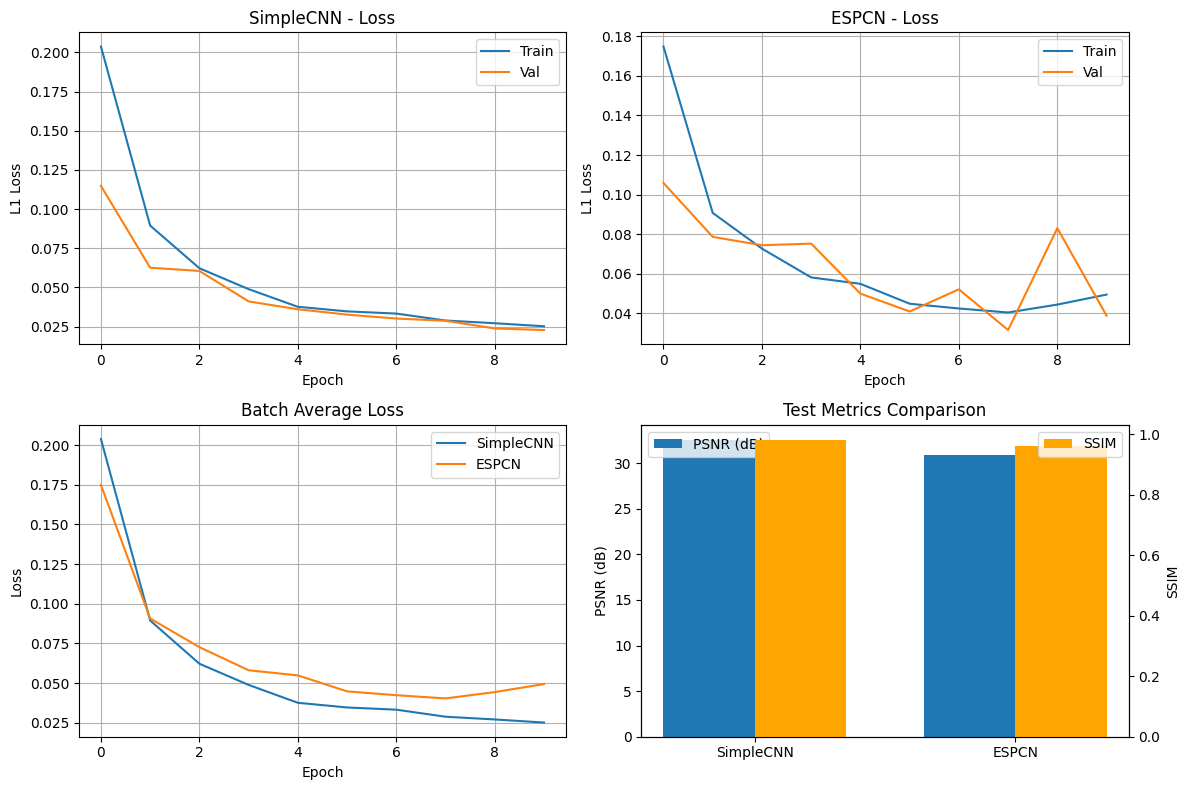

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(history_scratch['train_loss'], label='Train')
axes[0, 0].plot(history_scratch['val_loss'], label='Val')
axes[0, 0].set_title('SimpleCNN - Loss')
axes[0, 0].set_ylabel('L1 Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid()

axes[0, 1].plot(history_espcn['train_loss'], label='Train')
axes[0, 1].plot(history_espcn['val_loss'], label='Val')
axes[0, 1].set_title('ESPCN - Loss')
axes[0, 1].set_ylabel('L1 Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid()

axes[1, 0].plot(history_scratch['batch_avg_loss'], label='SimpleCNN')
axes[1, 0].plot(history_espcn['batch_avg_loss'], label='ESPCN')
axes[1, 0].set_title('Batch Average Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid()

models = ['SimpleCNN', 'ESPCN']
psnr_vals = [psnr_scratch, psnr_espcn]
ssim_vals = [ssim_scratch, ssim_espcn]

x = np.arange(len(models))
width = 0.35

axes[1, 1].bar(x - width/2, psnr_vals, width, label='PSNR (dB)')
ax2 = axes[1, 1].twinx()
ax2.bar(x + width/2, ssim_vals, width, label='SSIM', color='orange')
axes[1, 1].set_ylabel('PSNR (dB)')
ax2.set_ylabel('SSIM')
axes[1, 1].set_title('Test Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

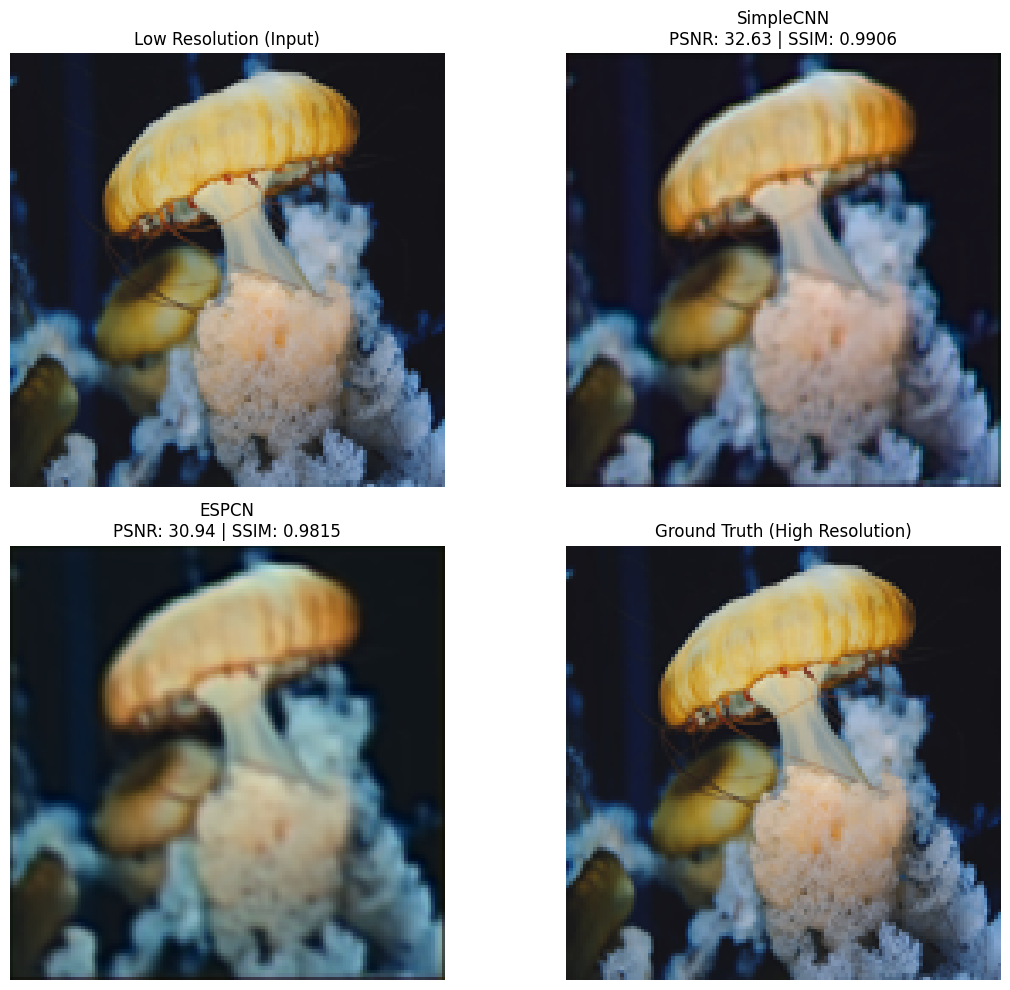

In [58]:
idx_demo = np.random.randint(0, len(test_dataset))
low_demo, high_demo = test_dataset[idx_demo]

low_demo = low_demo.unsqueeze(0).to(device)
high_demo = high_demo.to(device)

model_scratch.eval()
model_espcn.eval()

with torch.no_grad():
    out_scratch = model_scratch(low_demo)
    out_espcn = model_espcn(low_demo)

low_img = np.clip(low_demo[0].cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
high_img = np.clip(high_demo.cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
out_scratch_img = np.clip(out_scratch[0].cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
out_espcn_img = np.clip(out_espcn[0].cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)

psnr_scratch_demo = psnr(out_scratch_img, high_img)
psnr_espcn_demo = psnr(out_espcn_img, high_img)
ssim_scratch_demo = ssim(out_scratch_img.astype(float), high_img.astype(float))
ssim_espcn_demo = ssim(out_espcn_img.astype(float), high_img.astype(float))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(low_img)
axes[0, 0].set_title('Low Resolution (Input)')
axes[0, 0].axis('off')

axes[0, 1].imshow(out_scratch_img)
axes[0, 1].set_title(f'SimpleCNN\nPSNR: {psnr_scratch_demo:.2f} | SSIM: {ssim_scratch_demo:.4f}')
axes[0, 1].axis('off')

axes[1, 0].imshow(out_espcn_img)
axes[1, 0].set_title(f'ESPCN\nPSNR: {psnr_espcn_demo:.2f} | SSIM: {ssim_espcn_demo:.4f}')
axes[1, 0].axis('off')

axes[1, 1].imshow(high_img)
axes[1, 1].set_title('Ground Truth (High Resolution)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()